# EON models

In this notebook, we will explore the EON model offered by the `entlearn` package.

In [1]:
from sklearn.model_selection import train_test_split
from entlearn.models.EON import EON
import matplotlib.pyplot as plt
import numpy as np
from entlearn.utils.synthetic_data import make_worm
import time
from scipy.spatial.distance import cdist
from scipy.special import softmax
np.random.seed(42)

T = 250
D = 10
X,y = make_worm(D=D, T=T, sigma=10, rng=np.random.default_rng(42))

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

# EON

The EON optimization problem is a minimization problem that aims to find the optimal parameters that minimize the following functional:
$$
\begin{equation}
\begin{array}{rcl}
L(\Gamma,\theta,S) & = & 
\sum\limits_{t=1}^{T}
\left(
\underbrace{
\sum\limits_{k_1=1}^{K_1} \lbrace \gamma_{(1)} \rbrace_{k_1,t} 
\sum\limits_{d=1}^{K_0} \lbrace \gamma_{(0)} \rbrace_{d,t} ~ \big( \lbrace X(t) \rbrace_{d} - S_{d,k_1} \big)^2 
}_{\textrm{input layer}}  
\right.
\\
& & ~~~~~~~~ -
\underbrace{
\sum\limits_{n=1}^{N}
\delta_n
\left(
 \sum\limits_{k_n = 1}^{K_n} \sum\limits_{k_{n+1} = 1}^{K_{n+1}}
\lbrace \gamma_{(n)} \rbrace_{k_n,t}
\lbrace \gamma_{(n+1)} \rbrace_{k_{n+1},t}
\log (\theta^{(n)}_{k_n,k_{n+1}})
\right)
}_{\textrm{deep layers}}
 \\
& &
\left.
~~~~~~~~ +
\underbrace{
\sum\limits_{n=0}^{N+1}
\epsilon_n \left( \sum\limits_{k_n=1}^{K_n} \lbrace \gamma_{(n)} \rbrace_{k_n,t} \log \lbrace \gamma_{(n)} \rbrace_{k_n,t}
\right)
}_{\textrm{entropy regularization}}
\right),
\end{array}
\end{equation}
$$

with the feasible sets:
$$\begin{equation}
\Omega_{\Gamma} :=
\left(~
\Omega_{\gamma_{(0)}}
\times
\mathbb{P}_{\textrm{L}}^{K_1 \times T} \times \dots \times \mathbb{P}_{\textrm{L}}^{K_{N+1} \times T}
~\right), ~~~
\Omega_{\theta} :=
\left(~
\mathbb{P}^{K_1 \times K_2}_{\textrm{L}} \times \dots \times \mathbb{P}^{K_{N} \times K_{N+1}}_{\textrm{L}}
~\right), ~~~
\Omega_{S} := \mathbb{R}^{K_0 \times K_1},
\end{equation}$$


In `entlearn`, we provide an object implementing the EON model, with a single layer, i.e., $N=1$.


In [2]:
mod = EON(
    epsT=1, 
    epsD=2e-2,
    K=9, 
    epsC=1e-1, 
    epsG=1e-9,
    anneals=50,
    random_state=42)

start = time.perf_counter()
m = mod.fit(X_train,y_train)
duration = time.perf_counter() - start 
print(f"It took {duration} seconds for {m.anneals} anneals to fit the model (so {duration/m.anneals} seconds per anneal)")
print(f"Performance on the training set: {m.score(X_train, y_train):.2f}, and on the test set {m.score(X_test, y_test):.2f}")

It took 0.18571900005917996 seconds for 50 anneals to fit the model (so 0.0037143800011835994 seconds per anneal)
Performance on the training set: 0.95, and on the test set 0.97


As for `eSPA` models, we also have access to the best model found during the hyperparameter search.
See the `eSPA` notebook for more details on the interface and properties of the model.

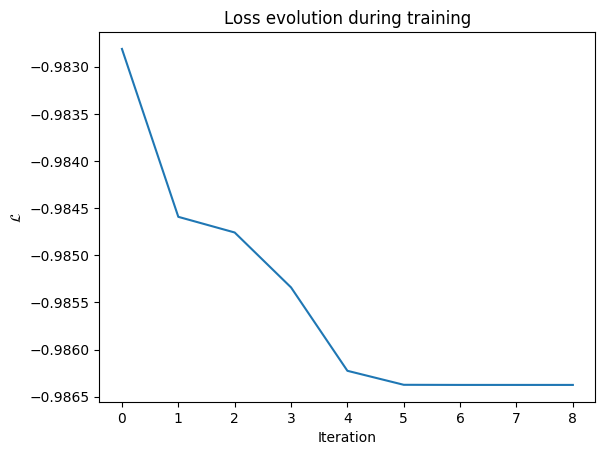

In [3]:
model = m.fitted_model_
plt.plot(model.losses_)
plt.xlabel("Iteration")
plt.ylabel(r"$\mathcal{L}$")
plt.title("Loss evolution during training")
plt.show()
plt.show()

EON is a generalization of eSPA, with some additional features, including
- $\gamma_{(0)}$, expressing the confidence on the input
- $\varepsilon_G$, a hyperparameter that controls the influence the softness of the affiliations


## $\gamma_{(0)}$
In this implementation, $\gamma_{(0)}$ can be constructed as the outer product of two stochastic vectors:
- $W_d$ is a vector of size $D$ that represents the confidence on the input features
- $W_t$ is a vector of size $T$ that represents the confidence on the individual data points

Text(0.5, 1.0, '$\\gamma_{(0)}$')

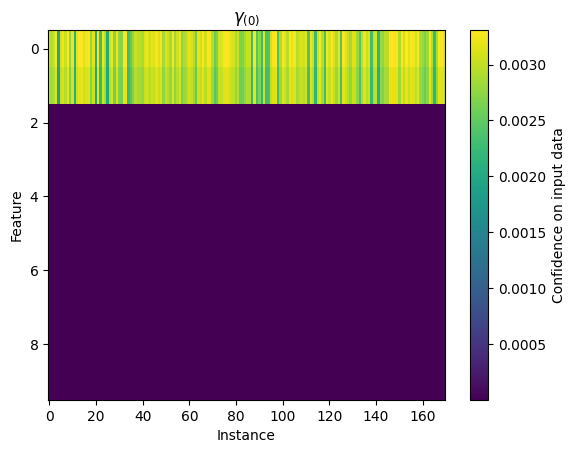

In [4]:
Wd = m.fitted_model_.Wd_
Wt = m.fitted_model_.Wt_

plt.imshow(np.outer(Wd, Wt), aspect="auto", interpolation="none")
plt.colorbar(label='Confidence on input data')
plt.xlabel("Instance")
plt.ylabel("Feature")
plt.title(r"$\gamma_{(0)}$")

## $\varepsilon_G$
The hyperparameter $\varepsilon_G$ controls the softness of the affiliations. 
As with the explanation of the eSPA hyperparameter $\varepsilon_C$, let us illustrate the effect of this hyperparameter in the following example.

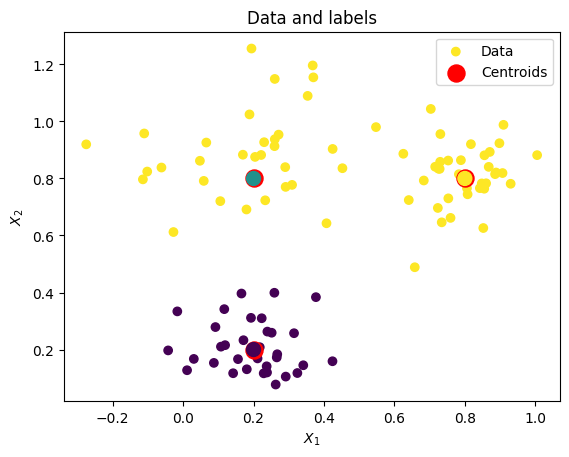

In [5]:
from sklearn.datasets import make_blobs
centroids = np.array([[.8,.8], [.2,.2], [.2,.8]])
X_example, y_example = make_blobs(n_samples=100, n_features=2,centers=centroids, cluster_std=[.1,.1,.2])

pi = np.zeros((100,2))
pi[y_example!=1,0] = 1
pi[y_example==1,1] = 1 

L = np.array([[1,0,0.5],[0,1,0.5]])

plt.scatter(X_example[:,0], X_example[:,1], c=pi[:,0], label="Data")
plt.scatter(centroids[:,0], centroids[:,1], s=150, c='r', label="Centroids")
plt.scatter(centroids[:,0], centroids[:,1], s=100, c=L[0,:])
plt.title('Data and labels')
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.legend()
plt.show()

With kmeans, we obtain by default hard affiliations for the data points, i.e., each point is sharply assigned to the closest centroid.

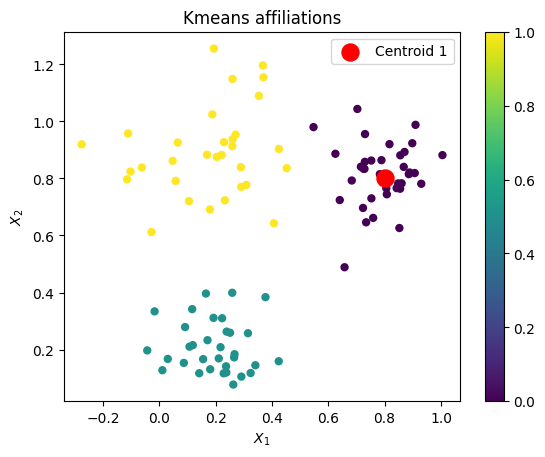

In [6]:
G_kmeans = cdist(X_example,centroids, "sqeuclidean")
Affiliations_kmeans = np.argmin(G_kmeans, axis=1)

plt.scatter(X_example[:,0], X_example[:,1], s=25, c=Affiliations_kmeans)
plt.scatter(centroids[0,0], centroids[0,1], s=150, c='r', label="Centroid 1")
plt.title('Kmeans affiliations')
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.colorbar()
plt.legend()
plt.show()

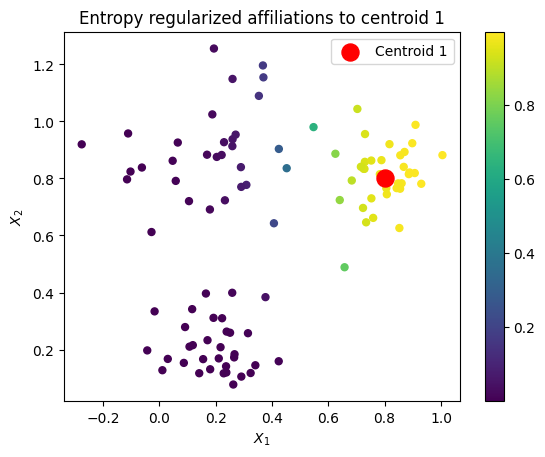

In [7]:
G_kmeans = cdist(X_example,centroids, "sqeuclidean") # distances between points and centroids
Affiliations_soft = softmax(-G_kmeans/1e-1,axis=1)

plt.scatter(X_example[:,0], X_example[:,1], s=25, c=Affiliations_soft[:,0])
plt.colorbar()
plt.scatter(centroids[0,0], centroids[0,1], s=150, c='r', label="Centroid 1")
plt.title('Entropy regularized affiliations to centroid 1')
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.legend()
plt.show()

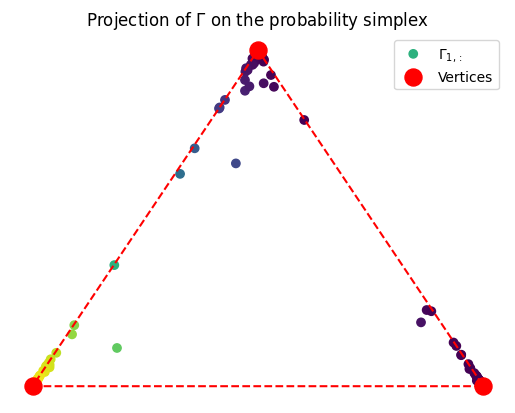

In [8]:
vertices = np.array([[0,0],[1,0],[.5,np.sqrt(3)/2]])
vertices_plot = np.concatenate((vertices, vertices[0:1,:]), axis=0)
proj = Affiliations_soft @ vertices

plt.scatter(proj[:,0], proj[:,1], c=Affiliations_soft[:,0], label=r"$\Gamma_{1,:}$")
plt.scatter(vertices[:,0], vertices[:,1], s=150, c='r', label="Vertices")
plt.plot(vertices_plot[:,0], vertices_plot[:,1], c='r', linestyle='--')
plt.title(r'Projection of $\Gamma$ on the probability simplex')
plt.legend()
plt.axis('off')
plt.show()

## Using EON

Similar to `eSPA`, it is possible to fit a single model (i.e., without annealing) using `EON_single` or to fit a model with annealing using `EON`.

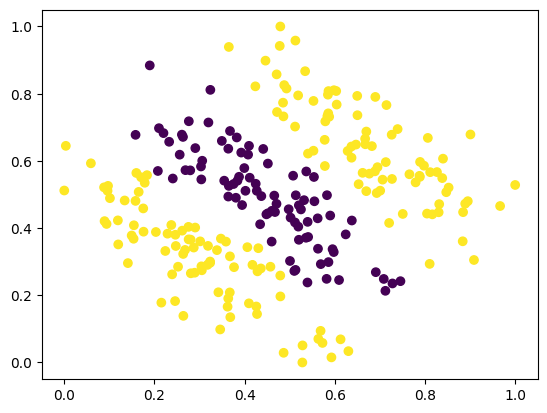

In [9]:
probas = mod.fitted_model_.predict_proba(X)
plt.scatter(X[:, 0], X[:, 1], c=probas[:,1])

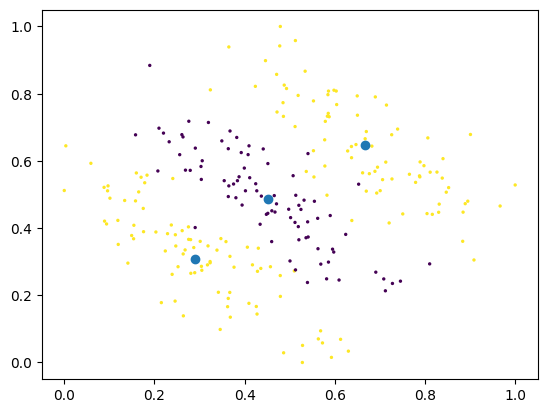

In [10]:
model = mod.fitted_model_

plt.scatter(X[:,0], X[:,1], c=y, s=2)
plt.scatter(model.C_[0,:], model.C_[1,:])

In [11]:
res = 50
grid_1d = np.linspace(-1.0, 2.0, res)
[xx,yy] = np.meshgrid(grid_1d,grid_1d)
X_grid = np.column_stack((yy.flatten(), xx.flatten()))
X_grid = np.hstack((X_grid, 0.5*np.ones((X_grid.shape[0],D-2))))

In [12]:
preds, conf = model.predict_proba_conf(X_grid)

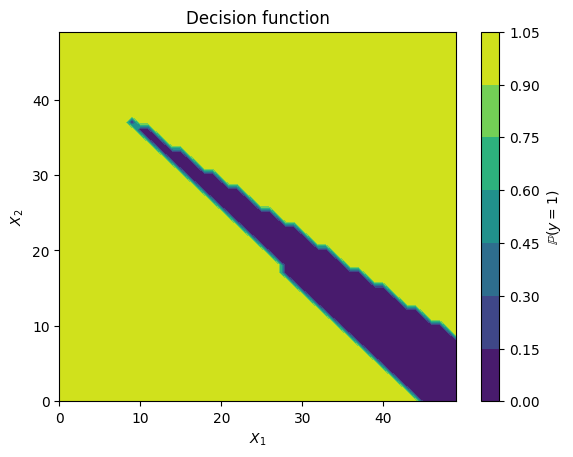

In [13]:
plt.contourf(preds[:,1].reshape(res,res))
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.title("Decision function")
plt.colorbar(label=r"$\mathbb{P}(y=1)$")
plt.show()

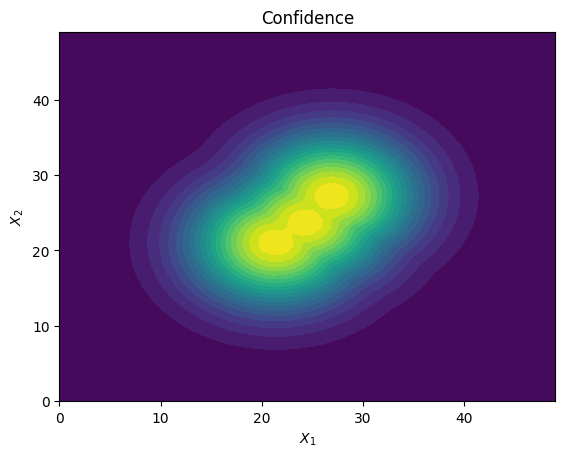

In [14]:
plt.contourf(conf.reshape(res,res), levels=20)
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.title("Confidence")
plt.show()